In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

%matplotlib inline

In [3]:
import torch
use_device = "cuda:0"
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device(use_device) #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 4
device#: 0
device name: NVIDIA A100-PCIE-40GB

torch: 1.10.0+cu113
cuda:  11.3
cudnn: 8200
dtype: torch.float32


# File locations

In [7]:
#input_dir = root_dir + "../nsd/output/multisubject/"
#joined_model_dir = input_dir + 'gnet8j_mpf_evc_Jan-18-2022_1148/' # 'gnet8j_mpf_evc_Jan-18-2022_1148/'
#roiwise_model_dir = input_dir + 'gnet8r_mpf_evc_Jan-17-2022_1738/'# 'gnet8r_mpf_evc_Jan-17-2022_1738/'

input_dir = root_dir + "output/multisubject/"
joined_model_dir = input_dir + 'gnet8j_mpf_evc_Feb-04-2022_1818/' 
roiwise_model_dir = input_dir + 'gnet8r_mpf_evc_Feb-05-2022_2105/'# 'gnet8r_mpf_evc_Feb-04-2022_1844/'

stim_dir = root_dir+'../../data/nsd/stims/'
voxel_dir = root_dir+'../../data/nsd/voxels/'

exp_design_file = root_dir+"../../data/nsd/nsd_expdesign.mat"

output_dir = joined_model_dir

# Reload joined GNet model files

In [8]:
joined_checkpoint = torch.load(joined_model_dir + 'model_params', map_location=use_device)
print (joined_checkpoint.keys())

dict_keys(['num_epochs', 'batch_size', 'holdout_frac', 'best_params', 'final_params', 'trn_loss_history', 'hold_loss_history', 'hold_cc_history', 'best_epoch', 'best_joint_cc_score', 'val_cc', 'input_mean', 'brain_nii_shape', 'voxel_index', 'voxel_roi', 'voxel_mask'])


## Voxel masks

In [9]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]

roi_group_names = ['V1', 'V2', 'V3', 'hV4']
roi_group = [[1,2],[3,4],[5,6], [7]]

In [10]:
subjects = list(joined_checkpoint['voxel_mask'].keys())
gnet8j_voxel_mask = joined_checkpoint['voxel_mask']
gnet8j_voxel_roi  = joined_checkpoint['voxel_roi']
gnet8j_voxel_index= joined_checkpoint['voxel_index']
gnet8j_brain_nii_shape= joined_checkpoint['brain_nii_shape']
gnet8j_val_cc = joined_checkpoint['val_cc']

# Reload ROI-wise models

In [12]:
roiwise_model_dirs = {
    'V1': '%smodel_params_V1' % roiwise_model_dir,
    'V2': '%smodel_params_V2' % roiwise_model_dir,
    'V3': '%smodel_params_V3' % roiwise_model_dir,
    'hV4': '%smodel_params_hV4' % roiwise_model_dir
    }

roiwise_checkpoint = {}
for r,t in roiwise_model_dirs.items():
    roiwise_checkpoint[r] = torch.load(t, map_location=use_device)

In [13]:
cp = roiwise_checkpoint[list(roiwise_model_dirs.keys())[0]]
subjects = list(cp['voxel_mask'].keys())
gnet8r_voxel_mask = cp['voxel_mask']
gnet8r_voxel_roi  = cp['voxel_roi']
gnet8r_voxel_index= cp['voxel_index']
gnet8r_brain_nii_shape= cp['brain_nii_shape']
#these masks should be the same for all model components

In [14]:
gnet8r_val_cc = {s: np.zeros_like(v).astype(np.float32) for s,v in gnet8r_voxel_roi.items()}

for k,(roi_name, cp) in enumerate(roiwise_checkpoint.items()):
    for s in gnet8r_voxel_roi.keys():
        
        group_mask = cp['group_mask'][s]
        gnet8r_val_cc[s][group_mask] = cp['val_cc'][s]

---
# Load NSD Data
## Load NSD voxel data

In [15]:
voxel_data_set = h5py.File(voxel_dir+'voxel_data_V1_4_part1.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data = voxel_data_dict['voxel_data']

voxel_data_set = h5py.File(voxel_dir+'voxel_data_V1_4_part2.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data.update(voxel_data_dict['voxel_data'])

voxel_data = {int(s): v for s,v in voxel_data.items()}
print (voxel_data.keys())

dict_keys([1, 2, 5, 6, 3, 4, 7, 8])


## Load NSD Stimuli

In [18]:
from src.load_nsd import image_feature_fn

stim_data = {}
for s in subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
    stim_data[s] = image_feature_fn(np.copy(image_data_set['stimuli']))
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', stim_data[s].shape, ', dtype:', stim_data[s].dtype, ', value range:',\
           np.min(stim_data[s][0]), np.max(stim_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 2  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 3  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 4  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 5  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 6  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 7  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0
--------  subject 8  -------
block size: (10000, 3, 227, 227) , dtype: float32 , value range: 0.0 1.0


## Data split

In [16]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

In [17]:
from src.load_nsd import ordering_split
trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data = {},{},{},{}

data_size, nnv = {}, {}
for k,s in enumerate(voxel_data.keys()):
    print ('--------  subject %d  -------' % s)
    data_size[s], nnv[s] = voxel_data[s].shape 

    trn_stim_ordering[s], trn_voxel_data[s], \
    val_stim_ordering[s], val_voxel_data[s] = \
        ordering_split(voxel_data[s], ordering, combine_trial=False)

del voxel_data

--------  subject 1  -------
Total number of voxels = 4627
--------  subject 2  -------
Total number of voxels = 3765
--------  subject 5  -------
Total number of voxels = 3685
--------  subject 6  -------
Total number of voxels = 4024
--------  subject 3  -------
Total number of voxels = 3778
--------  subject 4  -------
Total number of voxels = 3027
--------  subject 7  -------
Total number of voxels = 3201
--------  subject 8  -------
Total number of voxels = 3490


---
# Layerwise tuning masks

In [19]:
NN = 128
layerwise_tuning_masks = [np.zeros(shape=(int(4*NN))).astype(bool),
                np.zeros(shape=(int(4*NN))).astype(bool), 
                np.zeros(shape=(int(4*NN))).astype(bool), 
                np.zeros(shape=(int(4*NN))).astype(bool),
                np.zeros(shape=(int(4*NN))).astype(bool),
                np.zeros(shape=(int(4*NN))).astype(bool), 
                np.zeros(shape=(int(4*NN))).astype(bool)]
layerwise_tuning_masks[0][0:int(NN)] = True
layerwise_tuning_masks[1][int(NN):int(3*NN/2)] = True
layerwise_tuning_masks[2][int(3*NN/2):int(2*NN)] = True
layerwise_tuning_masks[3][int(2*NN):int(5*NN/2)] = True
layerwise_tuning_masks[4][int(5*NN/2):int(3*NN)] = True
layerwise_tuning_masks[5][int(3*NN):int(7*NN/2)] = True
layerwise_tuning_masks[6][int(7*NN/2):] = True

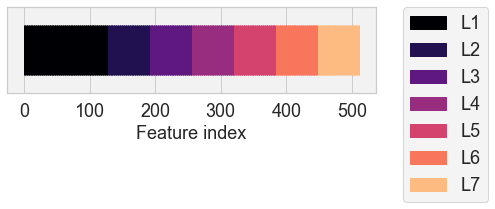

In [20]:
layer_cmap = [cm.get_cmap('magma', len(layerwise_tuning_masks)+1)(k) for k in range(len(layerwise_tuning_masks)+1)]

from PIL import Image
from matplotlib.patches import Patch

fig=plt.figure(figsize=(8, 2))
plt.subplots_adjust(left=0.01, bottom=0.35, right=.65, top=.95, wspace=0.16, hspace=0.)
legend_elements = [Patch(facecolor=layer_cmap[k], edgecolor=layer_cmap[k], label='L%d'%(k+1)) for k,tm in enumerate(layerwise_tuning_masks)]
for k,tm in enumerate(layerwise_tuning_masks):
    _=plt.plot(tm, marker='|', linestyle='None', color=layer_cmap[k], ms=50)
#_=plt.title('Feature index layer correspondence')
_=plt.xlabel('Feature index')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1.1))

In [26]:
filename = output_dir + "gnet8x_feature_layer_distribution%s"  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

# Bipartite tuning masks

In [21]:
NN = 128
bipartite_tuning_masks = [np.zeros(shape=(int(4*NN))).astype(bool),
                          np.zeros(shape=(int(4*NN))).astype(bool)]
bipartite_tuning_masks[0][0:int(2*NN)] = True
bipartite_tuning_masks[1][int(2*NN):] = True

bipartite_cmap = [cm.get_cmap('magma', len(bipartite_tuning_masks)+1)(k) for k in range(len(bipartite_tuning_masks)+1)]

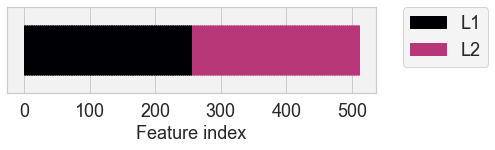

In [22]:
from PIL import Image
from matplotlib.patches import Patch

fig=plt.figure(figsize=(8, 2))
plt.subplots_adjust(left=0.01, bottom=0.35, right=.65, top=.95, wspace=0.16, hspace=0.)
legend_elements = [Patch(facecolor=bipartite_cmap[k], edgecolor=bipartite_cmap[k], label='L%d'%(k+1)) for k,tm in enumerate(bipartite_tuning_masks)]
for k,tm in enumerate(bipartite_tuning_masks):
    _=plt.plot(tm, marker='|', linestyle='None', color=bipartite_cmap[k], ms=50)
#_=plt.title('Feature index layer correspondence')
_=plt.xlabel('Feature index')
_=plt.ylim([.95, 1.05])
_=plt.yticks([])
_=plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.05, 1.1))

In [69]:
filename = output_dir + "gnet8x_feature_bipartite_distribution%s"  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

## Rebuild model
Prediction will take a considerable amount of time.

In [4]:
from src.torch_joint_training_unpacked_sequences import *
from src.torch_gnet import Encoder
from src.torch_mpf import Torch_LayerwiseFWRF

In [5]:
def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)

def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, T.from_numpy(xb).to(device))

In [6]:
# due to allocation issue at one time, the model instanciation is baked into these methods.
from src.tuning import gnet8j_tuning_analysis, gnet8r_tuning_analysis, tuning_and_spread

---
# Joined model tuning
## Layerwise GNet8j tuning

In [ ]:
subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc = \
     gnet8j_tuning_analysis(stim_data, val_voxel_data, val_stim_ordering, _pred_fn, joined_checkpoint, layerwise_tuning_masks, batch_size=100, n_resample=64, device=device)

In [68]:
from src.file_utility import save_stuff, flatten_dict, embed_dict

save_stuff( joined_model_dir + 'gnet8j_layerwise_tuning_var',
    flatten_dict({
            'val_cc': subject_total_val_cc,
            'incl_val_cc': subject_partition_incl_val_cc,
            'excl_val_cc': subject_partition_excl_val_cc
            }))

saved val_cc.1 in h5py file
saved val_cc.2 in h5py file
saved val_cc.5 in h5py file
saved val_cc.6 in h5py file
saved val_cc.3 in h5py file
saved val_cc.4 in h5py file
saved val_cc.7 in h5py file
saved val_cc.8 in h5py file
saved incl_val_cc.1 in h5py file
saved incl_val_cc.2 in h5py file
saved incl_val_cc.5 in h5py file
saved incl_val_cc.6 in h5py file
saved incl_val_cc.3 in h5py file
saved incl_val_cc.4 in h5py file
saved incl_val_cc.7 in h5py file
saved incl_val_cc.8 in h5py file
saved excl_val_cc.1 in h5py file
saved excl_val_cc.2 in h5py file
saved excl_val_cc.5 in h5py file
saved excl_val_cc.6 in h5py file
saved excl_val_cc.3 in h5py file
saved excl_val_cc.4 in h5py file
saved excl_val_cc.7 in h5py file
saved excl_val_cc.8 in h5py file


## GNet8j Bipartite tuning

In [ ]:
subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc = \
    gnet8j_tuning_analysis(stim_data, val_voxel_data, val_stim_ordering, _pred_fn, joined_checkpoint, bipartite_tuning_masks, batch_size=100, n_resample=64, device=device)

In [25]:
save_stuff( joined_model_dir + 'gnet8j_bibartite_tuning_var',
    flatten_dict({
            'val_cc': subject_total_val_cc,
            'incl_val_cc': subject_partition_incl_val_cc,
            'excl_val_cc': subject_partition_excl_val_cc
            }))

saved val_cc.1 in h5py file
saved val_cc.2 in h5py file
saved val_cc.5 in h5py file
saved val_cc.6 in h5py file
saved val_cc.3 in h5py file
saved val_cc.4 in h5py file
saved val_cc.7 in h5py file
saved val_cc.8 in h5py file
saved incl_val_cc.1 in h5py file
saved incl_val_cc.2 in h5py file
saved incl_val_cc.5 in h5py file
saved incl_val_cc.6 in h5py file
saved incl_val_cc.3 in h5py file
saved incl_val_cc.4 in h5py file
saved incl_val_cc.7 in h5py file
saved incl_val_cc.8 in h5py file
saved excl_val_cc.1 in h5py file
saved excl_val_cc.2 in h5py file
saved excl_val_cc.5 in h5py file
saved excl_val_cc.6 in h5py file
saved excl_val_cc.3 in h5py file
saved excl_val_cc.4 in h5py file
saved excl_val_cc.7 in h5py file
saved excl_val_cc.8 in h5py file


# Reload tuning file

In [22]:
data_set = h5py.File(joined_model_dir + "gnet8j_bibartite_tuning_var.h5py", 'r')
subject_total_val_cc          = {int(s): np.copy(d) for s,d in embed_dict(data_set)['val_cc'].items()}
subject_partition_incl_val_cc = {int(s): np.copy(d) for s,d in embed_dict(data_set)['incl_val_cc'].items()}
subject_partition_excl_val_cc = {int(s): np.copy(d) for s,d in embed_dict(data_set)['excl_val_cc'].items()}
data_set.close()

## Sorted validation accuracy distribution

In [ ]:
subj = 1
idx = np.argsort(subject_total_val_cc[subj][:,0])
val_cc_sorted = subject_total_val_cc[subj][idx]

plt.figure(figsize=(6,4))
plt.fill_between(gnet8j_val_cc[subj][idx], val_cc_sorted[:,0]-val_cc_sorted[:,1], val_cc_sorted[:,0]+val_cc_sorted[:,1], alpha=.2)

# Calculate tuning values/curves

In [28]:
subject_joined_incl_tunings, subject_joined_incl_tunings_err, subject_joined_incl_tuning_argmax, subject_joined_incl_tuning_spread,\
subject_joined_excl_tunings, subject_joined_excl_tunings_err, subject_joined_excl_tuning_argmax, subject_joined_excl_tuning_spread = \
    tuning_and_spread(subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc)

100%|██████████| 3490/3490 [00:00<00:00, 27520.44it/s]


In [ ]:
cmap = [cm.get_cmap('rainbow', len(subjects)+1)(k) for k in range(9)]

fig=plt.figure(figsize=(4*len(roi_group_names), 4))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.85, top=.95, wspace=0.1, hspace=0.05)
axes = [plt.subplot(1, len(roi_group_names), k+1) for k in range(len(roi_group_names))]

for subj in subjects:
    for k, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8r_voxel_roi[subj], roi_map, group_name=roi_group_names)):
        ax = axes[k]

        val_cc = subject_total_val_cc[subj][:,0]
        mask = np.logical_and(roi_mask, val_cc>.055)

        ax.errorbar(x=np.arange(len(subject_incl_tunings[subj][:,mask])),
                y=np.average(subject_incl_tunings[subj][:,mask], weights=np.square(val_cc[mask]), axis=1),
                yerr=np.average(subject_incl_tunings_err[subj][:,mask], weights=np.square(val_cc[mask]), axis=1),
                label='layerwise', lw=4, color='b')
        ax.errorbar(x=np.arange(len(subject_excl_tunings[subj][:,mask])),
                y=np.average(subject_excl_tunings[subj][:,mask], weights=np.square(val_cc[mask]), axis=1),
                yerr=np.average(subject_excl_tunings_err[subj][:,mask], weights=np.square(val_cc[mask]), axis=1),
                label='unique', lw=4, color='r')
#        print (np.sum(np.mean(subject_excl_tunings[subj][:,mask], axis=1)))
for k, roi_name in enumerate(roi_group_names):   
    ax.set_ylim([-100.0, 205.])
    ax = axes[k]
    if k==0:
        ax.set_ylabel('% Variance')
    else:
        ax.set_yticklabels([])
    ax.set_title(roi_name)
    ax.set_xticks(np.arange(len(subject_incl_tunings[subj])))
    ax.set_xlabel('Layer index')

In [ ]:
cmap = [cm.get_cmap('rainbow', len(subjects)+1)(k) for k in range(9)]

fig = plt.figure(figsize=(18,6))
plt.subplots_adjust(left=0.15, bottom=0.2, right=.75, top=.95, wspace=0.5, hspace=0.5)

for s in subjects:    
    
    Y, Ycc = [], []
    for k, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8j_voxel_roi[s], roi_map, group_name=roi_group_names)):
 
        val_cc = subject_total_val_cc[s][:,0]
        mask = np.logical_and(roi_mask, val_cc>.055)
        Y  += [ subject_joined_excl_tunings[s][0,mask], ]
        Ycc+= [ val_cc[mask], ]
    
    Ymin, Ymax = [np.percentile(y, 5) for y in Y], [np.percentile(y, 95) for y in Y]
    Yf = [y[np.logical_and(y>ymin, y<ymax)] for y,ymin,ymax in zip(Y, Ymin, Ymax)]
     
    Yparts = plt.violinplot(Yf, \
                         positions=np.arange(len(Y))+.12*s, \
                         vert=True, widths=0.1, showmeans=False, showextrema=False, showmedians=False)

    for pc in Yparts['bodies']:
        pc.set_facecolor(cmap[s])
        pc.set_edgecolor('black')
        pc.set_alpha(1)
        
    _=plt.plot(np.arange(len(Y))+.12*s, [np.average(y, weights=np.square(ycc), axis=0) for y,ycc in zip(Y, Ycc)], \
               marker='o', ms=6, color='k', linestyle='None')

plt.gca().set_xticks(np.arange(len(roi_group))+.5)
plt.gca().set_xticklabels(roi_group_names)
plt.ylabel('% Variance')
plt.ylim([0,100])

In [30]:
filename = joined_model_dir + "uvar_bipartite_gnet8j_mpf_bottom_summary_violin%s"  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

(0.0, 100.0)

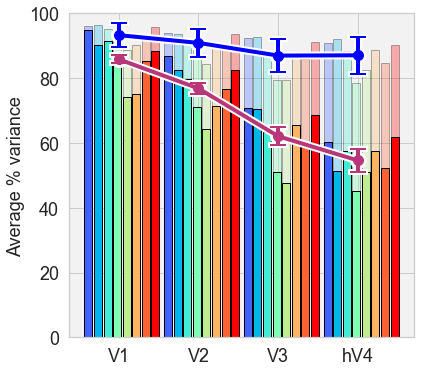

In [31]:
cmap = [cm.get_cmap('rainbow', len(subjects)+1)(k) for k in range(9)]

fig = plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15, bottom=0.2, right=.75, top=.95, wspace=0.5, hspace=0.5)

values_y, values_z, values_dy, values_dz = [], [], [], []
for s in subjects:    
    
    Y, Z, dY, dZ, Ycc = [], [], [], [], []
    for k, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8j_voxel_roi[s], roi_map, group_name=roi_group_names)):
 
        val_cc = subject_total_val_cc[s][:,0]
        mask = np.logical_and(roi_mask, val_cc>.055)
        Y  += [ subject_joined_excl_tunings[s][0,mask], ]
        Z  += [ subject_joined_incl_tunings[s][0,mask], ]
        dY  += [ subject_joined_excl_tunings_err[s][0,mask], ]
        dZ  += [ subject_joined_incl_tunings_err[s][0,mask], ]
        Ycc+= [ val_cc[mask], ]

    roi_average_z = [np.average(z, weights=np.square(ycc), axis=0) for z,ycc in zip(Z, Ycc)]
    roi_average_y = [np.average(y, weights=np.square(ycc), axis=0) for y,ycc in zip(Y, Ycc)]
    roi_average_dz = [np.average(dz, weights=np.square(ycc), axis=0) for dz,ycc in zip(dZ, Ycc)]
    roi_average_dy = [np.average(dy, weights=np.square(ycc), axis=0) for dy,ycc in zip(dY, Ycc)]
    
    #_=plt.errorbar(x=np.arange(len(Y))+.12*s, y=roi_average_z, yerr=roi_average_dz, linestyle='None', color=cmap[s], alpha=.3)
    _=plt.bar(x=np.arange(len(Y))+.12*s, height=roi_average_z, width=0.1, color=cmap[s], edgecolor='k', alpha=.3)
    #_=plt.errorbar(x=np.arange(len(Y))+.12*s, y=roi_average_y, yerr=roi_average_dy, linestyle='None', color=cmap[s])
    _=plt.bar(x=np.arange(len(Y))+.12*s, height=roi_average_y, width=0.1, color=cmap[s], edgecolor='k')
    
    values_y += [roi_average_y,]
    values_z += [roi_average_z,]
    values_dy += [roi_average_dy,]
    values_dz += [roi_average_dz,]    

#plt.plot(np.arange(len(roi_group))+.5, np.mean(np.array(values_y), axis=0), marker='o', ms=16, lw=8, color='w')
#plt.plot(np.arange(len(roi_group))+.5, np.mean(np.array(values_z), axis=0), marker='o', ms=16, lw=8, color='w')
plt.errorbar(np.arange(len(roi_group))+.5, y=np.mean(np.array(values_y), axis=0), yerr=np.sqrt(np.mean(np.array(values_dy)**2, axis=0))/ np.sqrt(8),\
             marker='o', ms=16, lw=8, capsize=10, capthick=6, elinewidth=8, ecolor='w', color='w')
plt.errorbar(np.arange(len(roi_group))+.5, y=np.mean(np.array(values_z), axis=0), yerr=np.sqrt(np.mean(np.array(values_dz)**2, axis=0)) / np.sqrt(8),\
             marker='o', ms=16, lw=8, capsize=10, capthick=6, elinewidth=8, ecolor='w', color='w')
###
plt.errorbar(np.arange(len(roi_group))+.5, y=np.mean(np.array(values_y), axis=0), yerr=np.sqrt(np.mean(np.array(values_dy)**2, axis=0))/ np.sqrt(8),\
             marker='o', ms=10, lw=4, capsize=8, capthick=2, color='#b73779', zorder=99)
plt.errorbar(np.arange(len(roi_group))+.5, y=np.mean(np.array(values_z), axis=0), yerr=np.sqrt(np.mean(np.array(values_dz)**2, axis=0)) / np.sqrt(8),\
             marker='o', ms=10, lw=4, capsize=8, capthick=2, color='#0000ff', zorder=99)

plt.gca().set_xticks(np.arange(len(roi_group))+.5)
plt.gca().set_xticklabels(roi_group_names)
plt.ylabel('Average % variance')
plt.ylim([0,100])

In [32]:
filename = joined_model_dir + "uvar_and_svar_bipartite_gnet8j_mpf_top_summary_bar%s"  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

---
# ROI-wise model tuning
## Layerwise GNet8r tuning

In [ ]:
subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc = \
    gnet8r_tuning_analysis(stim_data, val_voxel_data, val_stim_ordering, _pred_fn, roiwise_checkpoint, layerwise_tuning_masks, batch_size=100, n_resample=64, device=device)

In [40]:
save_stuff( roiwise_model_dir + 'gnet8r_layerwise_tuning_var',
    flatten_dict({
            'val_cc': subject_total_val_cc,
            'incl_val_cc': subject_partition_incl_val_cc,
            'excl_val_cc': subject_partition_excl_val_cc
            }))

saved val_cc.1 in h5py file
saved val_cc.2 in h5py file
saved val_cc.3 in h5py file
saved val_cc.4 in h5py file
saved val_cc.5 in h5py file
saved val_cc.6 in h5py file
saved val_cc.7 in h5py file
saved val_cc.8 in h5py file
saved incl_val_cc.1 in h5py file
saved incl_val_cc.2 in h5py file
saved incl_val_cc.3 in h5py file
saved incl_val_cc.4 in h5py file
saved incl_val_cc.5 in h5py file
saved incl_val_cc.6 in h5py file
saved incl_val_cc.7 in h5py file
saved incl_val_cc.8 in h5py file
saved excl_val_cc.1 in h5py file
saved excl_val_cc.2 in h5py file
saved excl_val_cc.3 in h5py file
saved excl_val_cc.4 in h5py file
saved excl_val_cc.5 in h5py file
saved excl_val_cc.6 in h5py file
saved excl_val_cc.7 in h5py file
saved excl_val_cc.8 in h5py file


## Bipartite GNet8r tuning

In [ ]:
subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc = \
    gnet8r_tuning_analysis(stim_data, val_voxel_data, val_stim_ordering, _pred_fn, roiwise_checkpoint, bipartite_tuning_masks, batch_size=100, n_resample=64, device=device)

In [24]:
save_stuff( roiwise_model_dir + 'gnet8r_bipartite_tuning_var',
    flatten_dict({
            'val_cc': subject_total_val_cc,
            'incl_val_cc': subject_partition_incl_val_cc,
            'excl_val_cc': subject_partition_excl_val_cc
            }))

saved val_cc.1 in h5py file
saved val_cc.2 in h5py file
saved val_cc.3 in h5py file
saved val_cc.4 in h5py file
saved val_cc.5 in h5py file
saved val_cc.6 in h5py file
saved val_cc.7 in h5py file
saved val_cc.8 in h5py file
saved incl_val_cc.1 in h5py file
saved incl_val_cc.2 in h5py file
saved incl_val_cc.3 in h5py file
saved incl_val_cc.4 in h5py file
saved incl_val_cc.5 in h5py file
saved incl_val_cc.6 in h5py file
saved incl_val_cc.7 in h5py file
saved incl_val_cc.8 in h5py file
saved excl_val_cc.1 in h5py file
saved excl_val_cc.2 in h5py file
saved excl_val_cc.3 in h5py file
saved excl_val_cc.4 in h5py file
saved excl_val_cc.5 in h5py file
saved excl_val_cc.6 in h5py file
saved excl_val_cc.7 in h5py file
saved excl_val_cc.8 in h5py file


In [ ]:
subj = 1
idx = np.argsort(subject_total_val_cc[subj][:,0])
val_cc_sorted = subject_total_val_cc[subj][idx]

plt.figure(figsize=(6,4))
plt.fill_between(gnet8r_val_cc[subj][idx], val_cc_sorted[:,0]-val_cc_sorted[:,1], val_cc_sorted[:,0]+val_cc_sorted[:,1], alpha=.2)

## Reload tuning file

In [ ]:
data_set = h5py.File(roiwise_model_dir + "gnet8r_bipartite_tuning_var.h5py", 'r')
subject_total_val_cc          = {int(s): np.copy(d) for s,d in embed_dict(data_set)['val_cc'].items()}
subject_partition_incl_val_cc = {int(s): np.copy(d) for s,d in embed_dict(data_set)['incl_val_cc'].items()}
subject_partition_excl_val_cc = {int(s): np.copy(d) for s,d in embed_dict(data_set)['excl_val_cc'].items()}
data_set.close()

In [26]:
subject_incl_tunings, subject_incl_tunings_err, subject_incl_tuning_argmax, subject_incl_tuning_spread, \
subject_excl_tunings, subject_excl_tunings_err, subject_excl_tuning_argmax, subject_excl_tuning_spread = \
    tuning_and_spread(subject_total_val_cc, subject_partition_incl_val_cc, subject_partition_excl_val_cc)

100%|██████████| 3490/3490 [00:00<00:00, 25189.58it/s]


(0.0, 105.0)

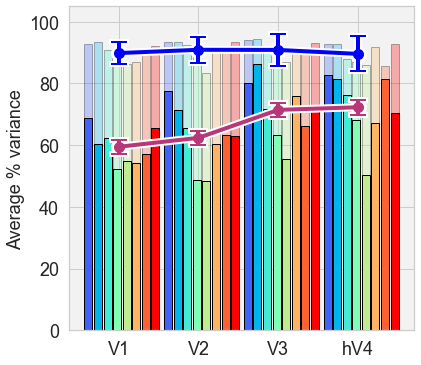

In [27]:
cmap = [cm.get_cmap('rainbow', len(subjects)+1)(k) for k in range(9)]

fig = plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15, bottom=0.2, right=.75, top=.95, wspace=0.5, hspace=0.5)

values_y, values_z, values_dy, values_dz = [], [], [], []
for s in subjects:    
    
    Y, Z, dY, dZ, Ycc = [], [], [], [], []
    for k, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8r_voxel_roi[s], roi_map, group_name=roi_group_names)):
        
        val_cc = subject_total_val_cc[s][:,0] # (mean, std)
        mask = np.logical_and(roi_mask, val_cc>.055)
        Y  += [ subject_excl_tunings[s][0,mask], ]
        Z  += [ subject_incl_tunings[s][0,mask], ]
        dY  += [ subject_excl_tunings_err[s][0,mask], ]
        dZ  += [ subject_incl_tunings_err[s][0,mask], ]
        Ycc+= [ val_cc[mask], ]

    roi_average_z = [np.average(z, weights=np.square(ycc), axis=0) for z,ycc in zip(Z, Ycc)]
    roi_average_y = [np.average(y, weights=np.square(ycc), axis=0) for y,ycc in zip(Y, Ycc)]
    roi_average_dz = [np.average(dz, weights=np.square(ycc), axis=0) for dz,ycc in zip(dZ, Ycc)]
    roi_average_dy = [np.average(dy, weights=np.square(ycc), axis=0) for dy,ycc in zip(dY, Ycc)]
    
    _=plt.bar(x=np.arange(len(Y))+.12*s, height=roi_average_z, width=0.1, color=cmap[s], edgecolor='k', alpha=.3)
    _=plt.bar(x=np.arange(len(Y))+.12*s, height=roi_average_y, width=0.1, color=cmap[s], edgecolor='k')
    
    values_y += [roi_average_y,]
    values_z += [roi_average_z,]
    values_dy += [roi_average_dy,]
    values_dz += [roi_average_dz,]    

plt.errorbar(np.arange(len(roi_group))+.5, y=np.mean(np.array(values_y), axis=0), yerr=np.sqrt(np.mean(np.array(values_dy)**2, axis=0))/ np.sqrt(8),\
             marker='o', ms=16, lw=8, capsize=10, capthick=6, elinewidth=8, ecolor='w', color='w')
plt.errorbar(np.arange(len(roi_group))+.5, y=np.mean(np.array(values_z), axis=0), yerr=np.sqrt(np.mean(np.array(values_dz)**2, axis=0)) / np.sqrt(8),\
             marker='o', ms=16, lw=8, capsize=10, capthick=6, elinewidth=8, ecolor='w', color='w')
###
plt.errorbar(np.arange(len(roi_group))+.5, y=np.mean(np.array(values_y), axis=0), yerr=np.sqrt(np.mean(np.array(values_dy)**2, axis=0))/ np.sqrt(8),\
             marker='o', ms=10, lw=4, capsize=8, capthick=2, color='#b73779', zorder=99)
plt.errorbar(np.arange(len(roi_group))+.5, y=np.mean(np.array(values_z), axis=0), yerr=np.sqrt(np.mean(np.array(values_dz)**2, axis=0)) / np.sqrt(8),\
             marker='o', ms=10, lw=4, capsize=8, capthick=2, color='#0000ff', zorder=99)

plt.gca().set_xticks(np.arange(len(roi_group))+.5)
plt.gca().set_xticklabels(roi_group_names)
plt.ylabel('Average % variance')
plt.ylim([0,105])

In [28]:
filename = roiwise_model_dir + "uvar_and_svar_bipartite_gnet8r_mpf_bottom_summary_err%s"  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

# Comparision

/usr/local/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 40.49999999999994, 'gnet8j <--> gnet8r')

<Figure size 576x576 with 0 Axes>

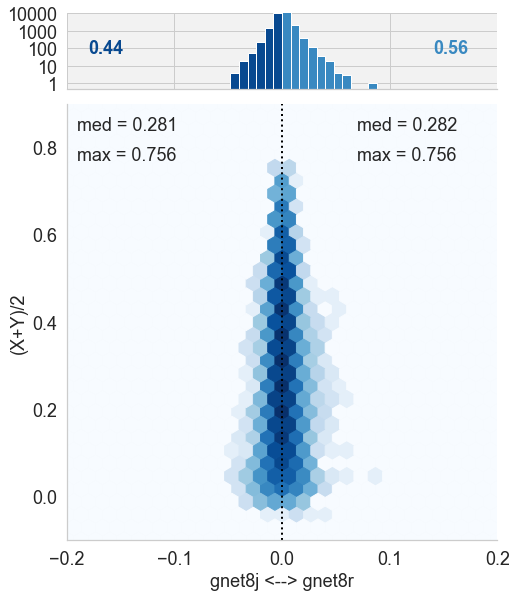

In [29]:
from src.plots import plot_fwrf_paper_compare

x = np.concatenate([v for s,v in gnet8r_val_cc.items()])
y = np.concatenate([v for s,v in gnet8j_val_cc.items()])

fig2b=plt.figure(figsize=(8, 8))
fig2b=plot_fwrf_paper_compare(x, y, 0.055, [-.2, .2], [-.1, .9])
ax=fig2b.ax_joint
ax.text(x=-.2+.01, y=.84, s='med = %.3f'%np.median(np.nan_to_num(y)), fontsize=18)
ax.text(x=-.2+.01, y=.77, s='max = %.3f'%np.max(np.nan_to_num(y)), fontsize=18)
ax.text(x=.2 - .13, y=.84, s='med = %.3f'%np.median(np.nan_to_num(x)), fontsize=18)
ax.text(x=.2 - .13, y=.77, s='max = %.3f'%np.max(np.nan_to_num(x)), fontsize=18)
plt.xlabel('gnet8j <--> gnet8r')

In [39]:
filename = output_dir + 'model_advantage_gnet8j_v_gnet8r_all_subjects%s'  % (saveext)
fig2b.savefig(filename, **savearg)
plt.close()

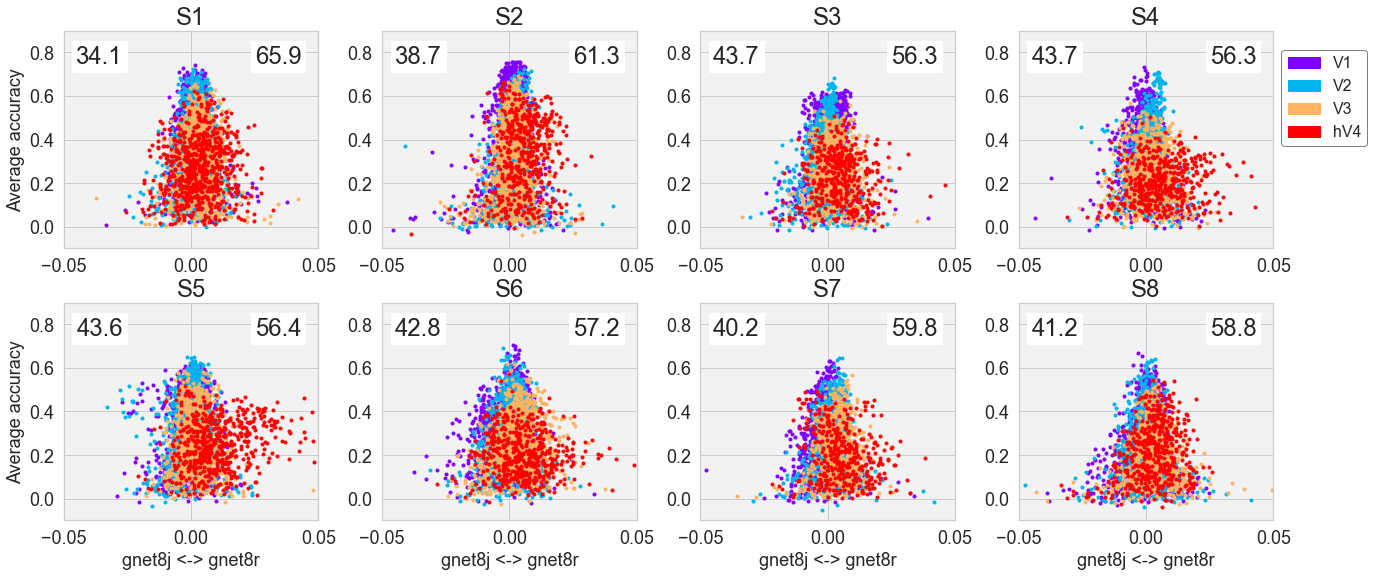

In [40]:
fig=plt.figure(figsize=(24,8))
plt.subplots_adjust(left=0.15, bottom=0.1, right=.85, top=.95, wspace=0.25, hspace=0.25)
axes = [plt.subplot(2, 4, k+1) for k in range(len(subjects))]
for k,s in enumerate(subjects):
    
    X = gnet8r_val_cc[s] 
    Y = gnet8j_val_cc[s]
    
    # gnet8j - anet,  X - Z
    plt.sca(axes[k])
    for i, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8j_voxel_roi[s], roi_map)):                
        mask = roi_mask
        plt.plot( (X - Y)[mask], ((Y + X)/2)[mask], linestyle='None', marker='.', color=roi_cmap[i])
      
    plt.text(-.045, .75, '%.01f'%(np.sum(Y-X>0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
    plt.text(.025, .75, '%.01f'%(np.sum(X-Y>0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))    
    plt.xlim([-.05,.05])
    plt.ylim([-.1,.9])
    plt.title('S%d'%(k+1))
    if k%4==0:
        plt.ylabel('Average accuracy')
    if k>=4:
        plt.xlabel('gnet8j <-> gnet8r')
    ax = plt.gca()
    ax.set_xticks([-.05, 0, .05])
     
plt.sca(axes[3])        
legend_elements = [Patch(facecolor=roi_cmap[i], edgecolor=roi_cmap[i], \
    label=roi_name) for i,roi_name in enumerate(roi_group_names)]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1., 0.95), fontsize=16, framealpha=1., facecolor='white', edgecolor='gray')

In [41]:
filename = output_dir + "gnet8r_v_gnet8j_val_cc_compare_by_subject%s"  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

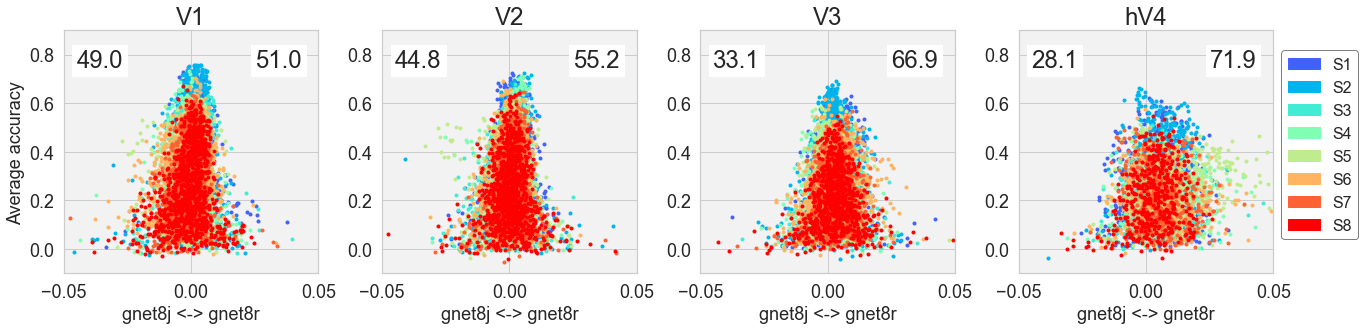

In [42]:
fig=plt.figure(figsize=(24,4.5))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.85, top=.9, wspace=0.25, hspace=0.25)
XY_roi_compare = {roi: [] for roi in roi_group_names}
axes = [plt.subplot(1, 4, k+1) for k in range(len(roi_group_names))]

for k,s in enumerate(subjects):
    
    X = gnet8r_val_cc[s] 
    Y = gnet8j_val_cc[s]

    for i, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8j_voxel_roi[s], roi_map, roi_group_names)):                
        plt.sca(axes[i])
        mask = roi_mask
        plt.plot( (X - Y)[mask], ((X+Y)/2)[mask], linestyle='None', marker='.', color=subj_cmap[s])
    
        XY_roi_compare[roi_name] += [(X - Y)[mask],]

        plt.xlim([-.05,.05])
        plt.ylim([-.1,.9])
        plt.title(roi_name)
        ax = plt.gca()
        ax.set_xticks([-.05, 0, .05])
    
    for i,roi_name in enumerate(roi_group_names):
        
        plt.sca(axes[i])
        X = np.concatenate(XY_roi_compare[roi_name])
        plt.text(-.045, .75, '%.01f'%(np.sum(X<0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
        plt.text(.025, .75, '%.01f'%(np.sum(X>0)*100/len(X)), fontsize=24, bbox=dict(facecolor='w'))  
        if i==0:
            plt.ylabel('Average accuracy')
            
        plt.xlabel('gnet8j <-> gnet8r')
                
plt.sca(axes[-1])          
legend_elements = [Patch(facecolor=subj_cmap[s], edgecolor=subj_cmap[s], label='S%d'%s) for s in subjects]
plt.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1., 0.95), fontsize=16, framealpha=1., facecolor='white', edgecolor='gray')

In [43]:
filename = output_dir + "gnet8r_v_gnet8j_val_cc_compare_by_roi%s"  % (saveext)
fig.patch.set_alpha(0.)
fig.savefig(filename, **savearg)
plt.close()

# Extra plotting routine

In [ ]:
cmap = [cm.get_cmap('rainbow', len(subjects)+1)(k) for k in range(9)]

fig=plt.figure(figsize=(4*len(roi_group_names), 4))
plt.subplots_adjust(left=0.15, bottom=0.15, right=.85, top=.95, wspace=0.1, hspace=0.05)
axes = [plt.subplot(1, len(roi_group_names), k+1) for k in range(len(roi_group_names))]

for subj in subjects:
    for k, (roi_mask, roi_name) in enumerate(iterate_roi(roi_group, gnet8r_voxel_roi[subj], roi_map, group_name=roi_group_names)):
        ax = axes[k]

        val_cc = subject_total_val_cc[subj][:,0]
        mask = np.logical_and(roi_mask, val_cc>.055)

        ax.errorbar(x=np.arange(len(subject_incl_tunings[subj][:,mask])),
                y=np.average(subject_incl_tunings[subj][:,mask], weights=np.square(val_cc[mask]), axis=1),
                yerr=np.average(subject_incl_tunings_err[subj][:,mask], weights=np.square(val_cc[mask]), axis=1),
                label='layerwise', lw=4, color=cmap[subj])
        ax.errorbar(x=np.arange(len(subject_excl_tunings[subj][:,mask])),
                y=np.average(subject_excl_tunings[subj][:,mask], weights=np.square(val_cc[mask]), axis=1),
                yerr=np.average(subject_excl_tunings_err[subj][:,mask], weights=np.square(val_cc[mask]), axis=1),
                label='unique', lw=4, color=cmap[subj], alpha=.5)
#        print (np.sum(np.mean(subject_excl_tunings[subj][:,mask], axis=1)))
for k, roi_name in enumerate(roi_group_names):   
    ax.set_ylim([-100.0, 205.])
    ax = axes[k]
    if k==0:
        ax.set_ylabel('% Variance')
    else:
        ax.set_yticklabels([])
    ax.set_title(roi_name)
    ax.set_xticks(np.arange(len(subject_incl_tunings[subj])))
    ax.set_xlabel('Layer index')